CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_9")

In [3]:
from utils import *
from models import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [6]:
# # Train data transformations
# train_transforms = transforms.Compose([
#     transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
#     transforms.Resize((28, 28)),
#     transforms.RandomRotation((-15., 15.), fill=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
#     ])

# # Test data transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])

train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
     ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
     ])



CODE BLOCK: 4

In [7]:
# train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.CIFAR10('../data', train=True, download=True)
# test_data = datasets.CIFAR10('../data', train=False, download=True)

100%|██████████| 170498071/170498071 [00:24<00:00, 6890056.69it/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


CODE BLOCK: 5

In [8]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CODE BLOCK: 6

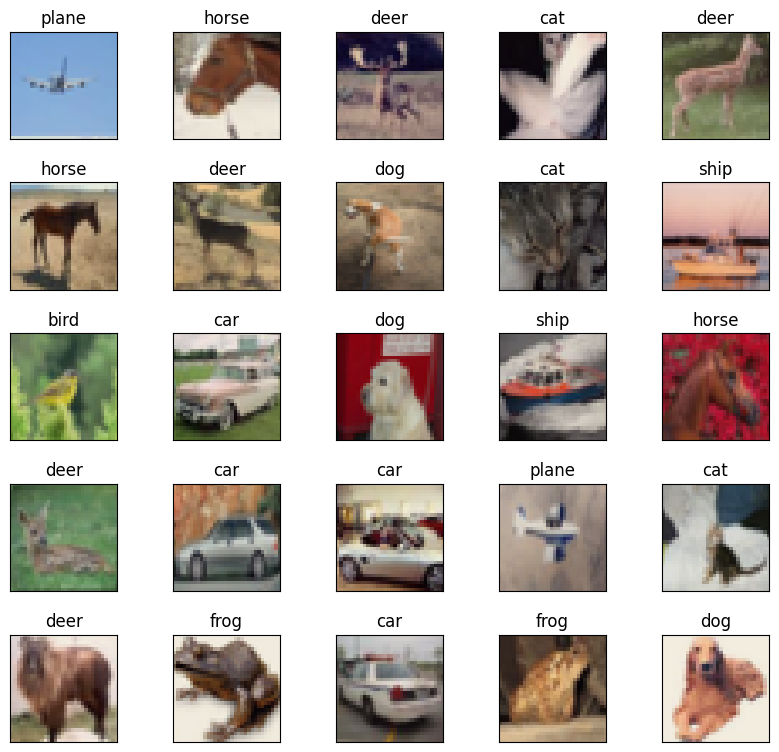

In [11]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10(batch_data,batch_label,classes,denormalise = True)


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = s9_base_model().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 31, 31]          16,416
              ReLU-8           [-1, 32, 31, 31]               0
       BatchNorm2d-9           [-1, 32, 31, 31]              64
           Conv2d-10           [-1, 32, 16, 16]           9,248
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 16, 16, 16]             528
           Conv2d-14           [-1, 32,

CODE BLOCK: 8

In [13]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [14]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 40

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.4738 Batch_id=97 Accuracy=32.29: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


Test set: Average loss: 1.5143, Accuracy: 4382/10000 (43.82%)

Epoch 2


Train: Loss=1.1159 Batch_id=97 Accuracy=51.10: 100%|██████████| 98/98 [00:16<00:00,  6.04it/s]


Test set: Average loss: 1.2287, Accuracy: 5538/10000 (55.38%)

Epoch 3


Train: Loss=1.1122 Batch_id=97 Accuracy=60.16: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Test set: Average loss: 1.1391, Accuracy: 5834/10000 (58.34%)

Epoch 4


Train: Loss=1.0620 Batch_id=97 Accuracy=65.34: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]


Test set: Average loss: 1.0008, Accuracy: 6404/10000 (64.04%)

Epoch 5


Train: Loss=0.8212 Batch_id=97 Accuracy=69.81: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


Test set: Average loss: 0.9396, Accuracy: 6655/10000 (66.55%)

Epoch 6


Train: Loss=0.7454 Batch_id=97 Accuracy=72.99: 100%|██████████| 98/98 [00:17<00:00,  5.58it/s]


Test set: Average loss: 0.8554, Accuracy: 7025/10000 (70.25%)

Epoch 7


Train: Loss=0.8386 Batch_id=97 Accuracy=75.47: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


Test set: Average loss: 0.8330, Accuracy: 7131/10000 (71.31%)

Epoch 8


Train: Loss=0.7127 Batch_id=97 Accuracy=77.35: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]


Test set: Average loss: 0.7886, Accuracy: 7262/10000 (72.62%)

Epoch 9


Train: Loss=0.5852 Batch_id=97 Accuracy=79.51: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]


Test set: Average loss: 0.7254, Accuracy: 7501/10000 (75.01%)

Epoch 10


Train: Loss=0.6241 Batch_id=97 Accuracy=80.85: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]


Test set: Average loss: 0.7734, Accuracy: 7348/10000 (73.48%)

Epoch 11


Train: Loss=0.4796 Batch_id=97 Accuracy=82.18: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]


Test set: Average loss: 0.7555, Accuracy: 7471/10000 (74.71%)

Epoch 12


Train: Loss=0.4956 Batch_id=97 Accuracy=83.37: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]


Test set: Average loss: 0.7467, Accuracy: 7465/10000 (74.65%)

Epoch 13


Train: Loss=0.5800 Batch_id=97 Accuracy=84.62: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]


Test set: Average loss: 0.7057, Accuracy: 7650/10000 (76.50%)

Epoch 14


Train: Loss=0.4033 Batch_id=97 Accuracy=85.65: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]


Test set: Average loss: 0.7115, Accuracy: 7678/10000 (76.78%)

Epoch 15


Train: Loss=0.4383 Batch_id=97 Accuracy=86.60: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Test set: Average loss: 0.7588, Accuracy: 7538/10000 (75.38%)

Epoch 16


Train: Loss=0.3296 Batch_id=97 Accuracy=87.61: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]


Test set: Average loss: 0.7045, Accuracy: 7760/10000 (77.60%)

Epoch 17


Train: Loss=0.3916 Batch_id=97 Accuracy=88.01: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Test set: Average loss: 0.7078, Accuracy: 7755/10000 (77.55%)

Epoch 18


Train: Loss=0.3322 Batch_id=97 Accuracy=88.95: 100%|██████████| 98/98 [00:16<00:00,  5.87it/s]


Test set: Average loss: 0.7434, Accuracy: 7675/10000 (76.75%)

Epoch 19


Train: Loss=0.3195 Batch_id=97 Accuracy=89.99: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]


Test set: Average loss: 0.7817, Accuracy: 7650/10000 (76.50%)

Epoch 20


Train: Loss=0.2633 Batch_id=97 Accuracy=90.66: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]


Test set: Average loss: 0.7756, Accuracy: 7658/10000 (76.58%)

Epoch 21


Train: Loss=0.2352 Batch_id=97 Accuracy=91.25: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]


Test set: Average loss: 0.7525, Accuracy: 7735/10000 (77.35%)

Epoch 22


Train: Loss=0.3158 Batch_id=97 Accuracy=91.43: 100%|██████████| 98/98 [00:16<00:00,  5.79it/s]


Test set: Average loss: 0.7728, Accuracy: 7730/10000 (77.30%)

Epoch 23


Train: Loss=0.2150 Batch_id=97 Accuracy=92.10: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]


Test set: Average loss: 0.8128, Accuracy: 7657/10000 (76.57%)

Epoch 24


Train: Loss=0.2864 Batch_id=97 Accuracy=92.34: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]


Test set: Average loss: 0.8444, Accuracy: 7565/10000 (75.65%)

Epoch 25


Train: Loss=0.2372 Batch_id=97 Accuracy=93.20: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Test set: Average loss: 0.8452, Accuracy: 7582/10000 (75.82%)

Epoch 26


Train: Loss=0.2251 Batch_id=97 Accuracy=93.65: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]


Test set: Average loss: 0.8367, Accuracy: 7675/10000 (76.75%)

Epoch 27


Train: Loss=0.2053 Batch_id=97 Accuracy=94.06: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]


Test set: Average loss: 0.9307, Accuracy: 7584/10000 (75.84%)

Epoch 28


Train: Loss=0.1587 Batch_id=97 Accuracy=94.90: 100%|██████████| 98/98 [00:16<00:00,  6.04it/s]


Test set: Average loss: 0.8876, Accuracy: 7648/10000 (76.48%)

Epoch 29


Train: Loss=0.2017 Batch_id=97 Accuracy=94.97: 100%|██████████| 98/98 [00:16<00:00,  6.00it/s]


Test set: Average loss: 0.8822, Accuracy: 7676/10000 (76.76%)

Epoch 30


Train: Loss=0.1477 Batch_id=97 Accuracy=95.75: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]


Test set: Average loss: 0.9348, Accuracy: 7666/10000 (76.66%)

Epoch 31


Train: Loss=0.1754 Batch_id=97 Accuracy=95.67: 100%|██████████| 98/98 [00:16<00:00,  6.04it/s]


Test set: Average loss: 0.8926, Accuracy: 7729/10000 (77.29%)

Epoch 32


Train: Loss=0.0857 Batch_id=97 Accuracy=96.18: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]


Test set: Average loss: 0.9338, Accuracy: 7695/10000 (76.95%)

Epoch 33


Train: Loss=0.1192 Batch_id=97 Accuracy=96.67: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


Test set: Average loss: 0.9437, Accuracy: 7725/10000 (77.25%)

Epoch 34


Train: Loss=0.1421 Batch_id=97 Accuracy=96.49: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]


Test set: Average loss: 0.9626, Accuracy: 7691/10000 (76.91%)

Epoch 35


Train: Loss=0.1162 Batch_id=97 Accuracy=96.58: 100%|██████████| 98/98 [00:16<00:00,  6.00it/s]


Test set: Average loss: 0.9682, Accuracy: 7657/10000 (76.57%)

Epoch 36


Train: Loss=0.0904 Batch_id=97 Accuracy=97.02: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]


Test set: Average loss: 1.0153, Accuracy: 7674/10000 (76.74%)

Epoch 37


Train: Loss=0.1009 Batch_id=97 Accuracy=97.35: 100%|██████████| 98/98 [00:15<00:00,  6.16it/s]


Test set: Average loss: 0.9767, Accuracy: 7744/10000 (77.44%)

Epoch 38


Train: Loss=0.0909 Batch_id=97 Accuracy=97.97: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]


Test set: Average loss: 1.0305, Accuracy: 7639/10000 (76.39%)

Epoch 39


Train: Loss=0.0950 Batch_id=97 Accuracy=98.01: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]


Test set: Average loss: 1.0661, Accuracy: 7702/10000 (77.02%)

Epoch 40


Train: Loss=0.0649 Batch_id=97 Accuracy=98.04: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]


Test set: Average loss: 1.0421, Accuracy: 7740/10000 (77.40%)



CODE BLOCK: 11

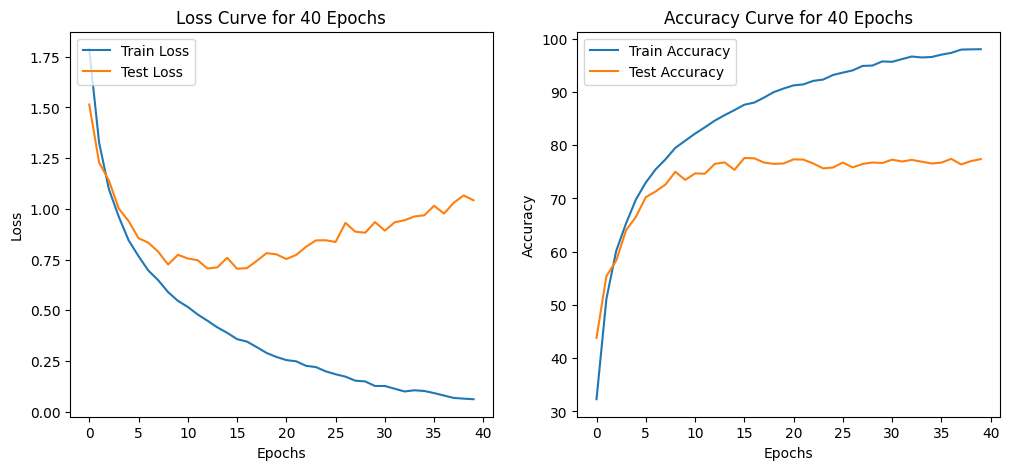

In [16]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc, num_epochs)

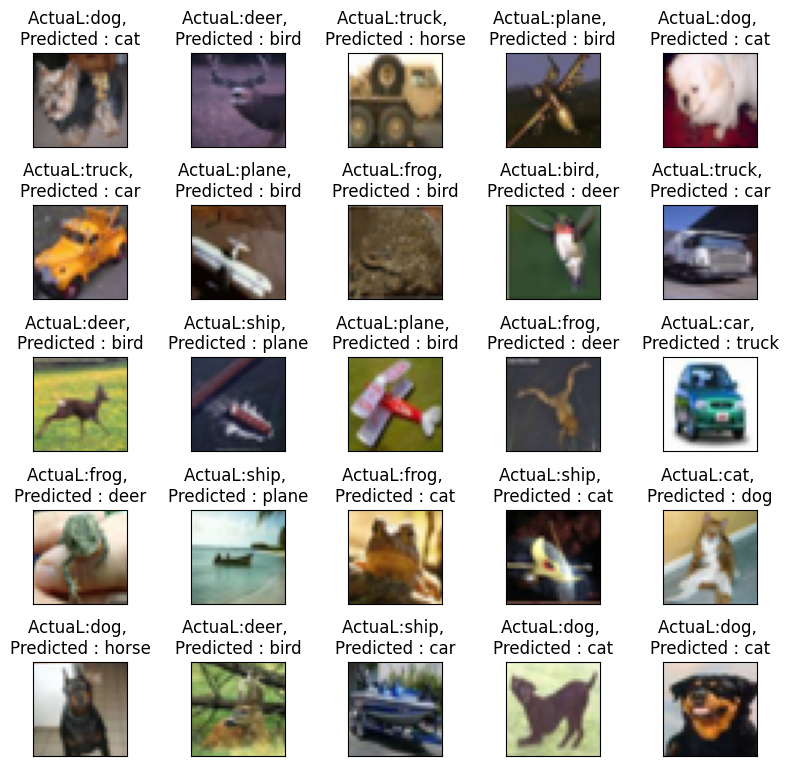

In [ ]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples(images, actual_label, predicted_label,classes, denormalise = True)
  break
